# Assignment 3: Use a single feature with different models

### Load full SVHN from HugginFace

In [3]:
# Import hugging face dataset
import huggingface_hub
from datasets import load_dataset

# Import cropped-digits dataset
dataset_cropped_digits_raw = load_dataset("ufldl-stanford/svhn", "cropped_digits")

extra-00000-of-00002.parquet:  39%|###8      | 199M/511M [00:00<?, ?B/s]

c:\Users\bimartin\AppData\Local\miniconda3\envs\iteso_aprendizaje_automatico\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bimartin\.cache\huggingface\hub\datasets--ufldl-stanford--svhn. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


extra-00001-of-00002.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

### Common functions

In [221]:
import numpy
import matplotlib.pyplot as plotter
from PIL import Image

def get_errors(y, y_predict):
    mse = numpy.mean((y - y_predict)**2)
    rmse = numpy.sqrt(mse)
    mae = numpy.mean(numpy.abs(y - y_predict))

    print(f'MSE:{mse} RMSE:{rmse} MAE:{mae}')

    return mse, rmse, mae

def get_labels_and_pixel_arrays(ds : object):
    # Need to extract only the data we care about in numpy arrays
    labels = []
    first_pixel_red_values = []
    ds_sample_size = len(ds)

    for sample in ds:
        labels.append(sample["label"])
        # Convert to RGB
        image_pixel_array = sample["image"].convert('RGB').load()
        # Append Red value of first pixel (0,0)
        first_pixel_red_values.append(image_pixel_array[0,0][0])
    
    # Convert to numpy
    labels = numpy.array(labels).reshape(ds_sample_size, 1)
    first_pixel_red_values = numpy.array(first_pixel_red_values).reshape(ds_sample_size, 1)
    return labels, first_pixel_red_values

### Extract the train dataset
Only use the Red RGB value of the first pixel of each image (1 simple Feature)

Create corresponding Label and Red value of first pixel arrays

In [220]:
# Get dataset subsets
ds_train = dataset_cropped_digits_raw["train"]
ds_test = dataset_cropped_digits_raw["test"]

# Get arrays of interest
labels_train, first_pixel_red_values_train = get_labels_and_pixel_arrays(ds_train)
labels_test, first_pixel_red_values_test = get_labels_and_pixel_arrays(ds_test)


### Run with LinearRegression model made on class

Training

Text(0, 0.5, 'loss')

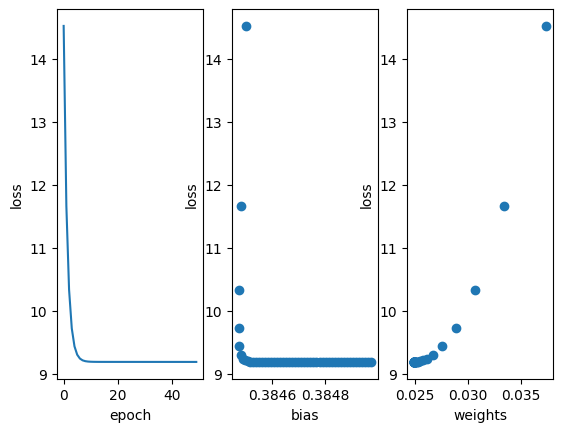

In [233]:
from LinearRegression import LinearRegression as LinearRegressionOwn

learning_rate = 0.00001
epochs = 50
model = LinearRegressionOwn(learning_rate=learning_rate, epochs=epochs)

weights, bias, losses_list, bias_list, weights_list = model.fit(first_pixel_red_values_train, labels_train)

plotter.subplot(1, 3, 1)
plotter.plot(numpy.arange(len(losses_list)), losses_list)
plotter.xlabel("epoch")
plotter.ylabel("loss")

plotter.subplot(1, 3, 2)
plotter.scatter(bias_list, losses_list)
plotter.xlabel("bias")
plotter.ylabel("loss")

plotter.subplot(1, 3, 3)
plotter.scatter(weights_list, losses_list)
plotter.xlabel("weights")
plotter.ylabel("loss")

Test prediction

In [223]:
own_model_prediction = model.predict(first_pixel_red_values_test)
own_model_errors = get_errors(labels_test, own_model_prediction)

MSE:9.209305943310913 RMSE:3.0346838292169602 MAE:2.475108148239295


### Run with Normal Equation

In [224]:
X_train_with_bias = numpy.c_[numpy.ones((len(first_pixel_red_values_train), 1)), first_pixel_red_values_train]
X_train_with_bias_transposed = X_train_with_bias.T
theta_array = numpy.linalg.inv(X_train_with_bias_transposed.dot(X_train_with_bias)).dot(X_train_with_bias_transposed).dot(labels_train)

X_test_with_bias = numpy.c_[numpy.ones((len(first_pixel_red_values_test),1)), first_pixel_red_values_test]
X_test_with_bias[0:5]

normal_equation_prediction = X_test_with_bias.dot(theta_array)
normal_equation_errors = get_errors(labels_test, normal_equation_prediction)

MSE:7.1727313354287645 RMSE:2.678195537190809 MAE:2.3112987704237615


### Run with SKLEARN

In [240]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(first_pixel_red_values_train, labels_train)

sklearn_linear_regression_prediction = model.predict(first_pixel_red_values_test)
sklean_linear_regression_errors = get_errors(labels_test, sklearn_linear_regression_prediction)

MSE:7.1727313354287645 RMSE:2.678195537190809 MAE:2.3112987704237615


# Plot error comparisons between 3 models

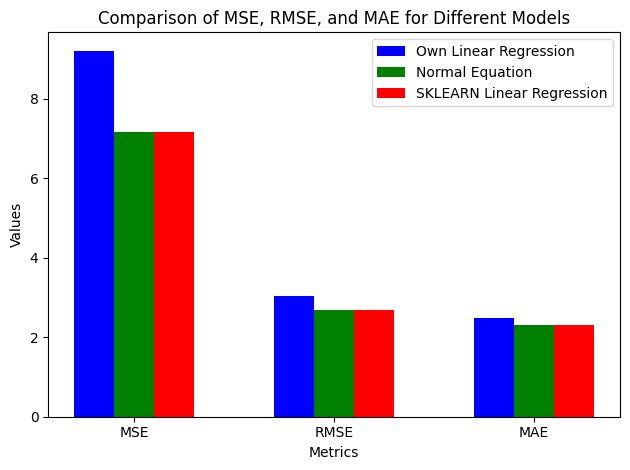

In [242]:
metrics = ['MSE', 'RMSE', 'MAE']
models = ['Own Linear Regression', 'Normal Equation', 'SKLEARN Linear Regression']
colors = ['b', 'g', 'r']

all_errors = numpy.array([
    own_model_errors,
    normal_equation_errors,
    sklean_linear_regression_errors
])

bar_width = 0.2
index = numpy.arange(len(metrics))
fig, ax = plotter.subplots()

bar_positions = [index + i * bar_width for i in range(len(models))]


for i, model_metrics in enumerate(all_errors):
    ax.bar(bar_positions[i], model_metrics, bar_width, color=colors[i], label=models[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MSE, RMSE, and MAE for Different Models')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plotter.tight_layout()
plotter.show()